In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re as re

In [49]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB_API_KEY")

import wandb
wandb.login(key=secret_value_0)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [50]:
import os

data_path = "/kaggle/input/allthenews"
print(os.listdir(data_path))

['articles2.csv', 'articles3.csv', 'articles1.csv']


In [51]:
df1 = pd.read_csv(f'{data_path}/articles1.csv')
df2 = pd.read_csv(f'{data_path}/articles2.csv')
df3 = pd.read_csv(f'{data_path}/articles3.csv')

dff = pd.concat([df1,df2,df3])
dff = dff[['publication', 'content']]

media_data = dff.sample(frac=1)
media_outlets = media_data['publication'].unique()

print(media_outlets)

['New York Times' 'Breitbart' 'Washington Post' 'New York Post'
 'Buzzfeed News' 'National Review' 'Reuters' 'Business Insider'
 'Talking Points Memo' 'Guardian' 'CNN' 'Atlantic' 'NPR' 'Vox' 'Fox News']


In [52]:
media_bias = {
    "Breitbart": "Right",
    "New York Post": "Lean Right",
    "NPR": "Lean Left",
    "CNN": "Lean Left",
    "Washington Post": "Lean Left",
    "Reuters": "Center",
    "Guardian": "Left",
    "New York Times": "Lean Left",
    "Atlantic": "Left",
    "Business Insider": "Lean Left",
    "National Review": "Lean Right",
    "Talking Points Memo": "NA",
    "Vox": "Left",
    "Buzzfeed News": "NA",
    "Fox News": "Right"
}


In [53]:
for media_outlet in media_outlets:
  if media_bias[media_outlet] and media_bias[media_outlet] != "NA":
    media_data.loc[media_data['publication'] == media_outlet, 'publication'] = media_bias[media_outlet]
  else:
    media_data = media_data[media_data['publication'] != media_outlet]

media_data = media_data.rename(columns={'publication': 'bias'})
media_data['bias'].value_counts()

bias
Lean Left     49154
Right         28135
Lean Right    23696
Left          20807
Center        10710
Name: count, dtype: int64

Total words: 53023615


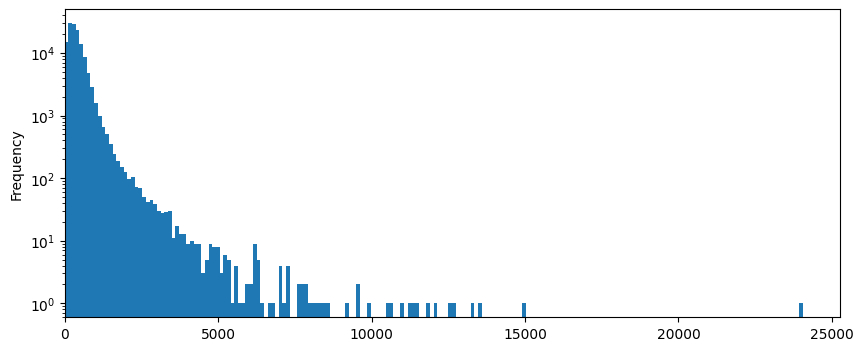

In [54]:
# 5. Data Preprocessing-1  for 'content' attribute

#Lower case, Replace publications and special charactor with empty space
import re
from sklearn.feature_extraction import text

URL_RE = re.compile(r"http\S+|www\S+")
HTML_RE = re.compile(r"<.*?>")
REPLACE_BY_SPACE_RE = re.compile(r"[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile(r"[^0-9a-z #+_]")
STOPWORDS = text.ENGLISH_STOP_WORDS

def clean_text(text):
    text = text.lower()
    text = URL_RE.sub(' ', text)
    text = HTML_RE.sub(' ', text)
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub(' ', text)
    for media_outlet in media_outlets:
        text = text.replace(str(media_outlet), '')
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text.strip()

media_data['content'] = media_data['content'].apply(clean_text)


s = media_data['content'].str.split().str.len()
plt.figure(figsize=(10, 4))
s.plot.hist(bins=200)
plt.xlim(0)
plt.yscale('log')
print("Total words:",s.sum())

In [55]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

sample = media_data.sample(frac=1, random_state=42)

x_sample = sample['content']
y_sample = le.fit_transform(sample['bias'])  # use same encoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

train_X, test_X, train_Y, test_Y = train_test_split(x_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample)

In [ ]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset
import multiprocessing

# CPU cores for parallelism
NUM_CORES = multiprocessing.cpu_count()

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_dict({"text": train_X.tolist(), "label": train_Y.tolist()})
test_dataset = Dataset.from_dict({"text": test_X.tolist(), "label": test_Y.tolist()})

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Fast batch tokenization
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512  # adjust if texts are long
    )

# Apply tokenization in parallel
train_dataset = train_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)
test_dataset = test_dataset.map(tokenize_function, batched=True, num_proc=NUM_CORES)

# Format for TensorFlow
train_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="tf", columns=["input_ids", "attention_mask", "label"])

In [64]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Training setup
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    load_best_model_at_end=True,
    fp16=True
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='weighted'
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # you can add metrics if needed
)

# Train
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_48/663072995.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.540200,0.532019,0.799291,0.808701,0.799291,0.795083
2,0.421300,0.412888,0.846987,0.849795,0.846987,0.847930
3,0.353600,0.403604,0.852157,0.853102,0.852157,0.851512


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1245, training_loss=0.5360799850708988, metrics={'train_runtime': 9713.477, 'train_samples_per_second': 32.738, 'train_steps_per_second': 0.128, 'total_flos': 4.212728389513728e+16, 'train_loss': 0.5360799850708988, 'epoch': 3.0})

In [65]:
# Evaluate
eval_results = trainer.evaluate()
distilbert_accuracy = eval_results['eval_accuracy']

print(eval_results)
print(f"DistilBERT Accuracy: {distilbert_accuracy}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.40360403060913086, 'eval_accuracy': 0.8521565223953813, 'eval_precision': 0.8531020178932278, 'eval_recall': 0.8521565223953813, 'eval_f1': 0.8515115534193904, 'eval_runtime': 274.4563, 'eval_samples_per_second': 96.558, 'eval_steps_per_second': 0.758, 'epoch': 3.0}
DistilBERT Accuracy: 0.8521565223953813


In [66]:
trainer.save_model("news_bias_model")
tokenizer.save_pretrained("news_bias_model")

('news_bias_model/tokenizer_config.json',
 'news_bias_model/special_tokens_map.json',
 'news_bias_model/vocab.txt',
 'news_bias_model/added_tokens.json',
 'news_bias_model/tokenizer.json')